# Spotify Streaming Data Exploration
The data in this notebook covers my streaming history from 2021/8/5 - 2022/8/4. It was downloaded from Spotify via the service's "Get My Data" feature.

This notebook contains an exploration of listening habits, and song preferences over time.

### Table of Contents:
* Reading and Formating JSON Data
* Most Played Artists by Month
* Podcast v. Music Listening Habits
* Breakdown of Song Level Data
* Most Played Artists by Hour of the Day
* Longest Sessions Spent Continuously Listening to Music
* Most Skipped Songs by Playlist

## Reading and Formating JSON Data

In [406]:
# Import Libraries
import numpy as np
import pandas as pd
import json

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [407]:
# Load Streaming Data
path = 'data/StreamingHistory0.json'

f = open(path)
strm = json.load(f)
f.close()

strm[-1]

{'endTime': '2022-08-04 19:46',
 'artistName': 'The Indycar Fan Podcast',
 'trackName': 'Sonsio Grad Prix at Road America',
 'msPlayed': 1567230}

In [408]:
# Load Library Data
path = 'data/YourLibrary.json'

f = open(path)
liby = json.load(f)
f.close()

liby.keys()

dict_keys(['tracks', 'albums', 'shows', 'episodes', 'bannedTracks', 'artists', 'bannedArtists', 'other'])

In [409]:
# Load Playlist Data
path = 'data/Playlist1.json'

f = open(path)
plst = json.load(f)
f.close()

plst['playlists'][0]['items'][1]

{'track': {'trackName': 'One More Pull',
  'artistName': 'The Wellermen',
  'albumName': 'One More Pull',
  'trackUri': 'spotify:track:1Auv8vgYeK52K3bIY7Hre6'},
 'episode': None,
 'localTrack': None,
 'addedDate': '2022-07-28'}

In [410]:
# Create a data frame with all streaming data
from datetime import tzinfo

play_data = pd.DataFrame(columns=['artist', 'track', 's_played', 'm_played', 'dt'])

for i in range(len(strm)):
    play_data.loc[i,'artist'] = strm[i]['artistName']
    play_data.loc[i,'track'] = strm[i]['trackName']
    play_data.loc[i,'s_played'] = strm[i]['msPlayed'] * .001
    play_data.loc[i,'m_played'] = (strm[i]['msPlayed'] * .001) / 60
    play_data.loc[i,'dt'] = strm[i]['endTime']

play_data['dt'] = pd.to_datetime(play_data['dt'], format = '%Y-%m-%d %H:%M', errors ='coerce')
play_data['dt'] = play_data['dt'].dt.tz_localize('UTC')
play_data['dt'] = play_data['dt'].dt.tz_convert('US/Central')

play_data['date'] = play_data['dt'].dt.strftime('%x')
play_data['time'] = play_data['dt'].dt.strftime('%X')
play_data['hour'] = play_data['dt'].dt.strftime('%H')
play_data['month'] = play_data['dt'].dt.strftime('%Y-%m')

play_data.tail()

,artist,track,s_played,m_played,dt,date,time,hour,month
4503,The Intelligence from The Economist,Nancy meeting you here: a tetchy Taiwan trip,1029.04,17.150667,2022-08-04 07:17:00-05:00,08/04/22,07:17:00,07,2022-08
4504,The Longest Johns,Drunken Sailor,58.584,0.9764,2022-08-04 08:00:00-05:00,08/04/22,08:00:00,08,2022-08
4505,Back Of The Grid | F1 Podcast,2022 Hungarian GP Review - Silly Season And Si...,3240.347,54.005783,2022-08-04 08:56:00-05:00,08/04/22,08:56:00,08,2022-08
4506,Back Of The Grid | F1 Podcast,2022 Hungarian GP Review - Silly Season And Si...,0.812,0.013533,2022-08-04 13:22:00-05:00,08/04/22,13:22:00,13,2022-08
4507,The Indycar Fan Podcast,Sonsio Grad Prix at Road America,1567.23,26.1205,2022-08-04 14:46:00-05:00,08/04/22,14:46:00,14,2022-08


## Most Played Artists by Month

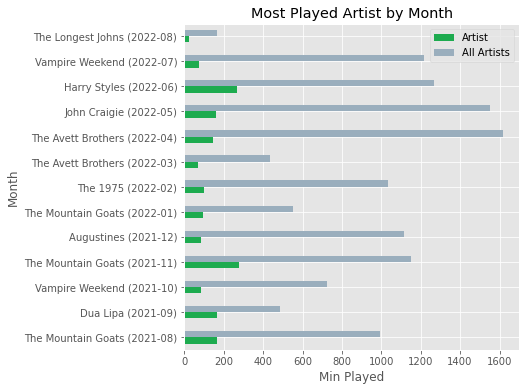

In [411]:
# Which artist I played the most each month?
by_month = play_data[play_data['s_played'] < 500][['month', 'artist', 'm_played']].groupby(['month', 'artist']).sum().reset_index()
time_by_month = play_data[play_data['s_played'] < 500][['month', 'm_played']].groupby('month').sum().rename(columns={'m_played':'total_played'})

by_month = by_month.join(time_by_month, on='month')

max_by_month = {}
for months in by_month['month'].unique():
    max_s = by_month[by_month['month'] == months]['m_played'].max()
    max_by_month[months] = max_s

for i in by_month.index:
    if by_month.loc[i,'m_played'] == max_by_month[by_month.loc[i,'month']]:
        pass
    else: by_month.drop(i,inplace=True)

by_month['label'] = by_month['artist'] + ' (' + by_month['month'] + ')'

by_month.set_index('label', drop=True, inplace=True)

by_month.plot(kind='barh', figsize=(6,6), color=['#1dab4f', '#9aaebd'])

plt.title('Most Played Artist by Month')
plt.ylabel('Month')
plt.xlabel('Min Played')
plt.legend(['Artist', 'All Artists'])

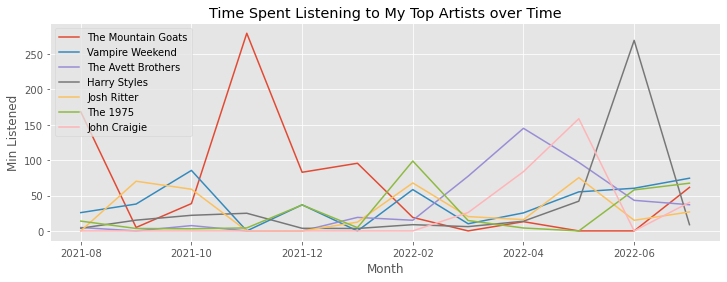

In [420]:
# How has the ammount of music played from each artist changed over time?
top_artists = play_data[play_data['s_played'] < 500][['artist','m_played']].groupby(['artist']).sum().sort_values('m_played', ascending=False).head(7).index.to_list()

over_time = play_data[play_data['artist'].isin(top_artists)][['month', 'artist','m_played']].groupby(['month', 'artist']).sum().reset_index()
over_time = over_time.pivot(index='month', columns='artist', values='m_played')

over_time.fillna(0, inplace=True)

over_time[top_artists].plot(kind='line', figsize=(12,4))
plt.title('Time Spent Listening to My Top Artists over Time')
plt.xlabel('Month')
plt.ylabel("Min Listened")
plt.legend(loc='upper left')

### Observations:
* You can easily see spikes for the Avett Brothers in April of 2022 and John Craigie in May of 2022 that corospond with concerts that I attended.
* There is also a corosponding spike for the release of Harry Styles latest album.
* You would think that The Mountian Goats did something in November of 2021, but they didn't. I was just really into them that month...

## Podcast v. Music Listening Habits

Text(0, 0.5, 'Month')

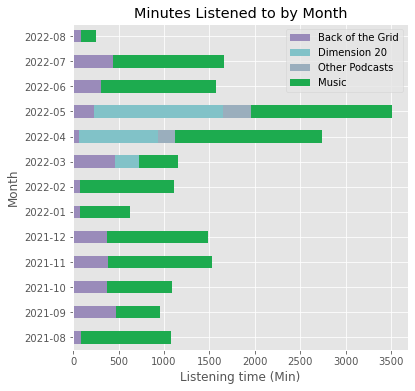

In [412]:
# What percent of my time is spent listening to podcasts v. music?
podcasts = ['The Intelligence from The Economist']

for i in range(len(liby['shows'])):
    podcasts.append(liby['shows'][i]['name'])

cast_by_month = play_data[play_data['artist'].isin(podcasts)][['month','m_played']].groupby('month').sum().rename(columns={'m_played':'Other Podcasts'})
cast_by_month = cast_by_month.join(by_month[['month','total_played']].set_index('month', drop=True).rename(columns={'total_played':'Music'}))
cast_by_month = cast_by_month.join(play_data[play_data['artist'] == 'Back Of The Grid | F1 Podcast'][['month','m_played']].groupby('month').sum().rename(columns={'m_played':'Back of the Grid'}))
cast_by_month = cast_by_month.join(play_data[play_data['artist'] == 'Dimension 20'][['month','m_played']].groupby('month').sum().rename(columns={'m_played':'Dimension 20'}))
cast_by_month['Other Podcasts'] = cast_by_month['Other Podcasts'] - (cast_by_month['Back of the Grid'] + cast_by_month['Dimension 20'])

cast_by_month[['Back of the Grid', 'Dimension 20', 'Other Podcasts', 'Music']].plot(kind='barh', stacked=True, figsize=(6,6), color=['#9a8bba' ,'#81c2c8' ,'#9aaebd', '#1dab4f'])
plt.title('Minutes Listened to by Month')
plt.xlabel('Listening time (Min)')
plt.ylabel('Month')

## Breakdown of Song Level Data

Note: This analysis uses an invented metric called "Average Percent Played". This is found by dividing the total number of seconds of a song that have been played by the length of the song and total number of times that song has been played. The result is a number between 1 and 100. The higher the number is, the more often the song is listened to in it's entierty. The lower it is, the more often the song is skipped.

In [413]:
# Which songs do I listen to all the way through the most
all_songs = list(play_data['track'].unique())
play_vol = pd.DataFrame(columns=['artist', 'total_plays', 'total_time', 'length'])

for sngs in all_songs:
    play_vol.at[sngs,'artist'] = play_data[play_data['track'] == sngs].reset_index().loc[0,'artist']
    
    df = play_data[play_data['track'] == sngs]
    play_vol.loc[sngs,'length'] = df['m_played'].max()
    play_vol.loc[sngs,'total_plays'] = df['m_played'].count()
    play_vol.loc[sngs,'total_time'] = df['m_played'].sum()

play_vol.dropna(inplace=True)
play_vol.drop(play_vol[(play_vol['total_plays'] < 4) | (play_vol['length'] < 2)].index, inplace=True) 
play_vol.sort_values('total_plays', ascending=False, inplace=True)
play_vol['ave_pct'] = play_vol['total_time'] / (play_vol['total_plays'] * play_vol['length'] * 0.01)

play_vol.head()

,artist,total_plays,total_time,length,ave_pct
Up the Wolves,The Mountain Goats,31,105.27,3.456667,98.239338
Damn These Vampires,The Mountain Goats,28,86.8318,3.4011,91.180374
This Year,The Mountain Goats,25,90.508133,3.88155,93.270094
Shuffle,Bombay Bicycle Club,24,85.335333,3.92155,90.669222
The Communists Have the Music,They Might Be Giants,23,51.8845,2.4611,91.660145


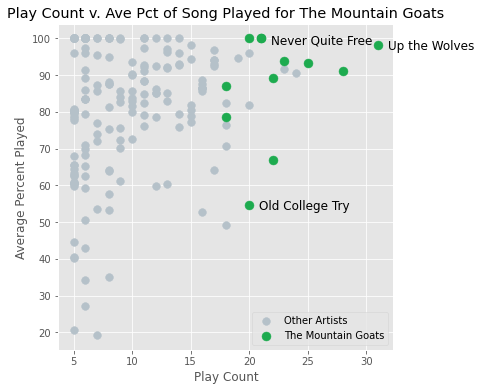

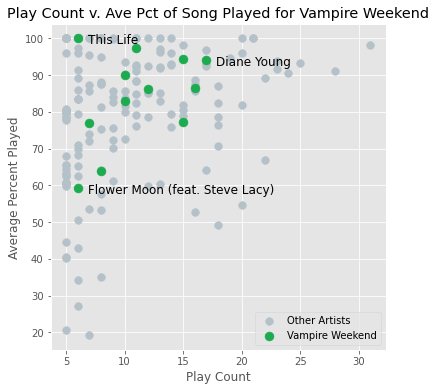

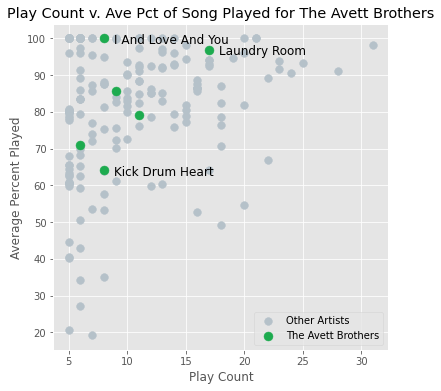

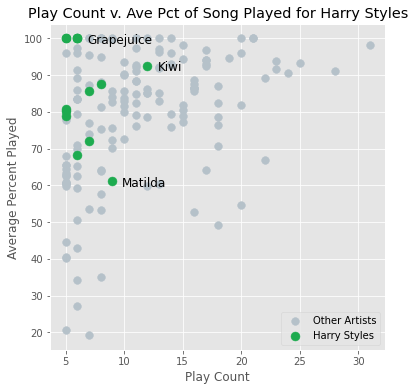

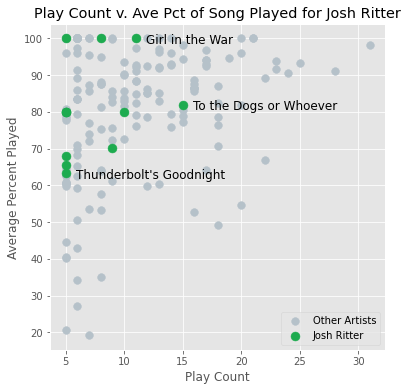

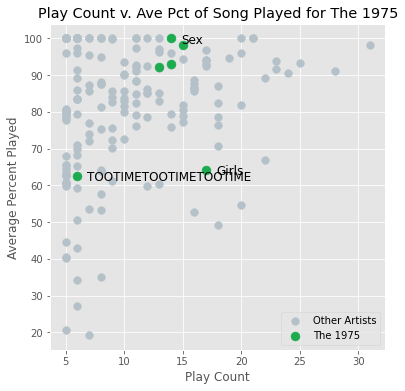

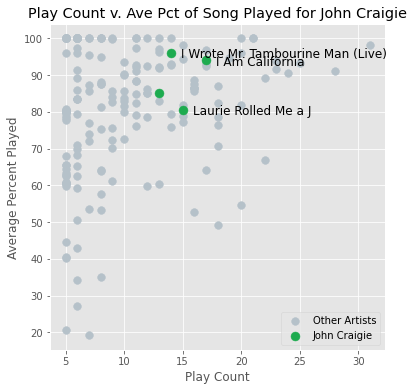

In [423]:
# For a given artist, how do their play stats match up against all other artists?
def plot_songs_by(x):
    fig, ax = plt.subplots()
    graph = play_vol[(play_vol['total_plays'] > 4) & ~(play_vol['artist'].isin(podcasts))]
    graph[graph['artist'] != x].plot(kind='scatter', x='total_plays', y='ave_pct', ax=ax, s=60, figsize=(6,6), color=['#b5c1c9'] )
    graph[graph['artist'] == x].plot(kind='scatter', x='total_plays', y='ave_pct', ax=ax, s=80, figsize=(6,6), color=['#1dab4f'] )

    tags = [
        graph[graph['artist'] == x].sort_values('total_plays', ascending=False).reset_index().loc[0,'index'],
        graph[graph['artist'] == x].sort_values('ave_pct', ascending=True).reset_index().loc[0,'index'],
        graph[graph['artist'] == x].sort_values(['ave_pct', 'total_plays'], ascending=False).reset_index().loc[0,'index']
    ]

    for k, v in graph[['total_plays', 'ave_pct']].iterrows():
        if k in tags:
            ax.annotate(k, v,
                        xytext=(10,-5), textcoords='offset points',
                        family='sans-serif', fontsize=12)

    plt.title('Play Count v. Ave Pct of Song Played for %s' %x)
    plt.xlabel('Play Count')
    plt.ylabel('Average Percent Played')
    plt.legend(['Other Artists', '%s' %x])

for x in top_artists:
    plot_songs_by(x)

### Observations:
* The Average Percent Played metic is intersting. I designed it to identify songs that I regularily skip (the idea was that if I skip a song regularily, the average listening durration would be low). However, often times the longs with the lowest average listeing durration are songs that I am trying to learn (and therefore regularily skip back to the beginning of).
* It seems the songs that rank highest in Average Percent Played are those in the middle of playlists that I mindlessly listen to while working, because they have the lowest chance of me skipping them.

## Most Played Artists by Hour of the Day

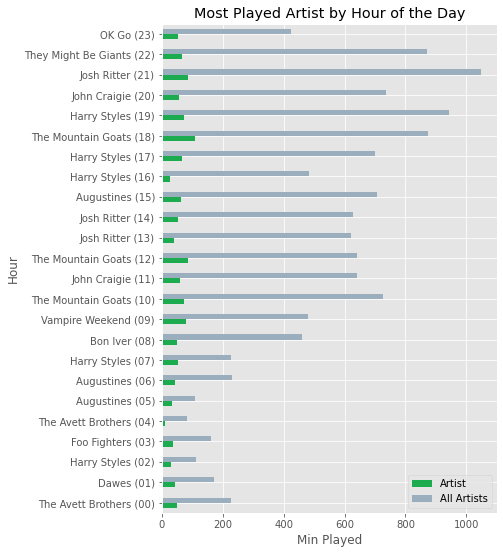

In [415]:
# Which artist I played the most each hour of the day?
by_hour = play_data[play_data['s_played'] < 500][['hour', 'artist', 'm_played']].groupby(['hour', 'artist']).sum().reset_index()
time_by_hour = play_data[play_data['s_played'] < 500][['hour', 'm_played']].groupby('hour').sum().rename(columns={'m_played':'total_played'})

by_hour = by_hour.join(time_by_hour, on='hour')

max_by_hour = {}
for hours in by_hour['hour'].unique():
    max_s = by_hour[by_hour['hour'] == hours]['m_played'].max()
    max_by_hour[hours] = max_s

for i in by_hour.index:
    if by_hour.loc[i,'m_played'] == max_by_hour[by_hour.loc[i,'hour']]:
        pass
    else: by_hour.drop(i,inplace=True)

by_hour['label'] = by_hour['artist'] + ' (' + by_hour['hour'] + ')'

by_hour.set_index('label', drop=True, inplace=True)

by_hour.plot(kind='barh', figsize=(6,9), color=['#1dab4f', '#9aaebd'])

plt.title('Most Played Artist by Hour of the Day')
plt.ylabel('Hour')
plt.xlabel('Min Played')
plt.legend(['Artist', 'All Artists'])

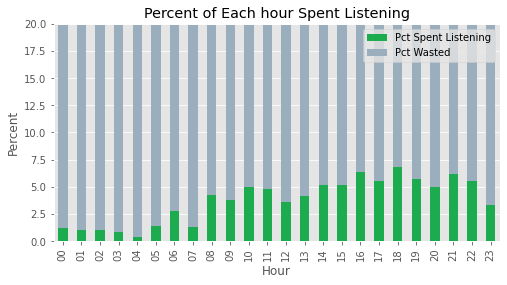

In [416]:
# When do I listin to the most spotify?
time_by_hour = play_data[['hour', 's_played']].groupby('hour').sum()
time_by_hour['s_played'] = time_by_hour['s_played'] / (365*36)
time_by_hour['s_other'] = 100 - time_by_hour['s_played']

time_by_hour.plot(kind='bar', figsize=(8,4), stacked=True, color=['#1dab4f', '#9aaebd'])
plt.title('Percent of Each hour Spent Listening')
plt.xlabel('Hour')
plt.ylabel('Percent')
plt.ylim(0,20)
plt.legend(['Pct Spent Listening', 'Pct Wasted'])

## Longest Sessions Spent Continuously Listening to Music

Text(0, 0.5, 'Date')

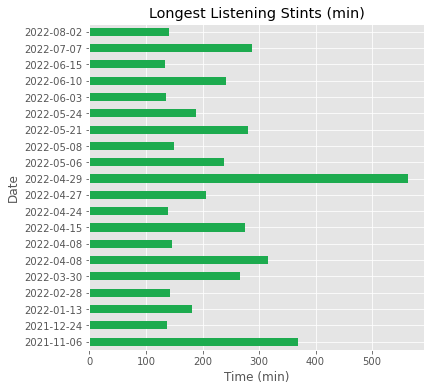

In [418]:
# What is the longest stretch of time I spent listening?
seq = play_data[['dt', 's_played']].copy()
spree = pd.DataFrame(columns=['date','start_time','end_time','length'])

date = 0
start_time = 0
end_time = 0

for i in range(0,seq.shape[0] - 1):
    i_end = seq.loc[i,'dt']
    i_start = i_end - timedelta(seconds = int(seq.loc[i,'s_played']))
    j_len = int(seq.loc[i+1,'s_played'])
    j_start = seq.loc[i+1,'dt'] - timedelta(seconds = j_len)
    
    if start_time == 0:
        start_time = i_start
        date = i_end.strftime('%Y-%m-%d')

    if (i_end + timedelta(seconds = (j_len + 300))) < j_start:
        end_time = i_end
        k = spree.shape[0]+1

        spree.loc[k,'date'] = date
        spree.loc[k,'start_time'] = start_time
        spree.loc[k,'end_time'] = end_time
        spree.loc[k,'length'] = int((end_time - start_time).total_seconds() / 60)

        date = 0
        start_time = 0
        end_time = 0

longest = spree.sort_values('length', ascending=False).head(20).sort_values('date')
longest.set_index('date', drop=True, inplace=True)

longest['length'].plot(kind='barh', figsize=(6,6), color=['#1dab4f'])
plt.title('Longest Listening Stints (min)')
plt.xlabel('Time (min)')
plt.ylabel('Date')


### Observatons:
* Most of these long sessions line up with roadtrips...

## Most Skipped Songs by Playlist

Text(0, 0.5, 'Song Name')

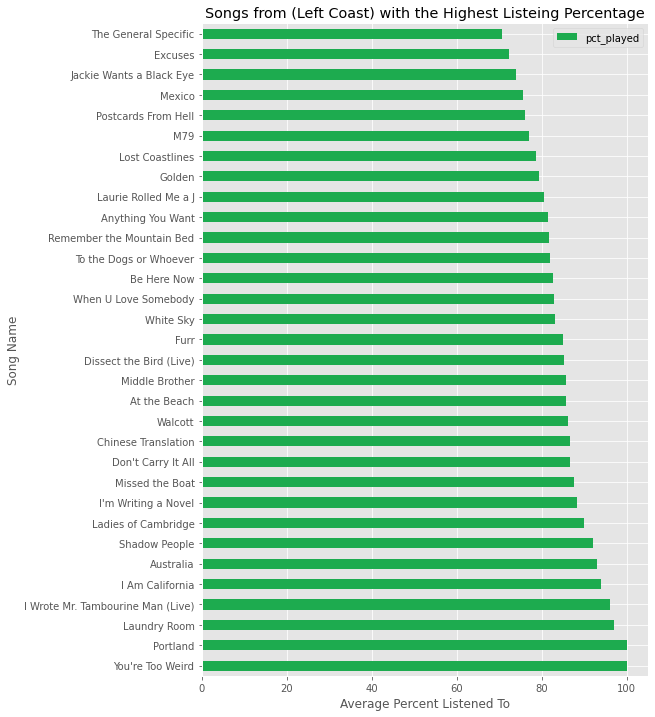

In [419]:
# What song is the most listened to on each playlist?
playlists = {}

for i in range(10):
    name = plst['playlists'][i]['name']
    track_list = []

    for j in range(len(plst['playlists'][i]['items'])):
        track_list.append(plst['playlists'][i]['items'][j]['track']['trackName'])

    playlists[name] = track_list

top_songs = {}

for plsts in playlists.keys():
    songs = playlists[plsts]
    pct = []
    
    for sngs in songs:
        df = play_data[play_data['track'] == sngs]
        length = df['m_played'].max()
        total_plays = df['m_played'].count()
        
        if (length < 2) | (total_plays < 3):
            pct.append(np.nan)
        else:
            total_time = df['m_played'].sum()
            pct.append(((total_time / total_plays) / length) * 100)

    top_songs[plsts] = pd.DataFrame({'track':songs, 'pct_played': pct}).sort_values('pct_played', ascending=False)
    

top_songs['Left Coast'].set_index('track').plot(kind='barh', figsize=(8,12), color=['#1dab4f'])
plt.title('Songs from (Left Coast) with the Highest Listeing Percentage')
plt.xlabel('Average Percent Listened To')
plt.ylabel('Song Name')